<a href="https://colab.research.google.com/github/commitit/NLP/blob/main/NLPv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

path_to_csv = '/content/gdrive/MyDrive/Data/review.csv'

Mounted at /content/gdrive


In [2]:
 df = pd.read_csv(path_to_csv)
 df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
!pip install nltk spacy scikit-learn gensim matplotlib seaborn pandas tqdm flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 36.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 27.1 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-p

In [3]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
#Remove leading spaces and line breaks
len(df)
for i in range(len(df)):
   df['review'][i] = df['review'][i].strip(' \n\t\r')
   df['review'][i] = df['review'][i].replace('<br />','')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
#split the dataset
#train dataset
train_data=df['review'][:40000]
train_label= df['sentiment'][:40000]

#test dataset
test_data=df['review'][40000:]
test_label= df['sentiment'][40000:]



In [7]:
# Convert the text data to TF-IDF vectors, max 10 words
vectorizer = TfidfVectorizer(max_features=10)

# `object.fit` followed by processing by `object.transform` or the
# joined `object.fit_transform` is the
train_vectors = vectorizer.fit_transform(train_data[:3])

In [13]:
# Convert the text data to TF-IDF vectors, all words, all data
vectorizer = TfidfVectorizer(stop_words='english',max_df = 0.1, max_features=10000 )

train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)


In [14]:
train_vectors.toarray().shape

(40000, 10000)

In [16]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['00', '000', '007', ..., 'zoom', 'zorro', 'zucco'], dtype=object)

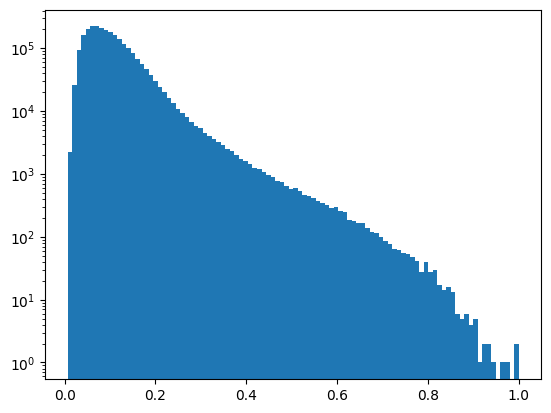

In [17]:
af = train_vectors.toarray().flatten()
# plot only present words (tfidf>0)
aff = af[af>0]
plt.hist(aff, 100, log=True);

In [18]:
# Define the model
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define the model hyperparameters
input_dim = train_vectors.shape[1]
hidden_dim = 200
output_dim = 2
#output = positive or negative


# Create the model instance
model =  Classifier(input_dim=input_dim,hidden_dim=hidden_dim, output_dim=output_dim)

# Define the optimizer and loss function
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and data to the device
model = model.to(device)
train_vectors_t = torch.tensor(train_vectors.toarray(), dtype=torch.float).to(device)
train_labels_t = torch.tensor(train_label, dtype=torch.long).to(device)
test_vectors_t = torch.tensor(test_vectors.toarray(), dtype=torch.float).to(device)
test_labels_t = torch.tensor(test_label, dtype=torch.long).to(device)

# Training loop
def train(model, optimizer, criterion):
    # set model to train mode
    model.train()

    optimizer.zero_grad()
    predictions = model(train_vectors_t)
    loss = criterion(predictions, train_labels_t)

    # perform backpropagation
    loss.backward()
    optimizer.step()

# Evaluation loop
def evaluate(model):
    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        predictions = model(test_vectors_t)
        predicted_labels = torch.argmax(predictions, dim=1)
        accuracy = torch.sum(predicted_labels == test_labels_t).item() / len(test_labels_t)
    return accuracy

# Training and evaluation loop
NUM_EPOCHS = 20
accuracy_arr = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train(model, optimizer, criterion)
    accuracy = evaluate(model)
    #print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Accuracy: {accuracy:.4f}")

    accuracy_arr.append(accuracy)

# plot the accuracy evolution
plt.plot(accuracy_arr)
print(max(accuracy_arr))

ValueError: too many dimensions 'str'

In [20]:
sample = train_data[24]
sample_label = train_label[24]
print (sample_label)

negative
